# Inference 
- metaファイルから読み込み

In [1]:
import init

In [8]:
import os
from glob import glob
import json
import torch
import argparse
import numpy as np

from utils import idx2word, interpolate, AttributeDict
from models.model_utils import to_var, to_tensor
from models.model_kwbase import SentenceVAE

In [3]:
def load_json(path):
    with open(path, 'r') as file:
        return json.load(file)

In [4]:
import pandas as pd
pd.set_option("display.max_colwidth", 500) # 1セルに500文字入る
pd.set_option("display.max_rows", 100) # 100行表示できる

In [6]:
data_name = 'adcrawl'

top_dir = os.path.abspath('..')
runs_dir = f'{top_dir}/runs'
data_base_dir = f'{top_dir}/data'
data_dir = f'{data_base_dir}/{data_name}'
assert os.path.exists(data_dir)
print(f'top_dir: {top_dir}\nruns_dir: {runs_dir}\ndata_dir: {data_dir}')

top_dir: /root/user/work/Sentence-VAE
runs_dir: /root/user/work/Sentence-VAE/runs
data_dir: /root/user/work/Sentence-VAE/data/adcrawl


In [9]:
print('\n'.join(glob(f'{runs_dir}/*')))

/root/user/work/Sentence-VAE/runs/vae_adcrawl_TS=2020-03-17-101018_BS=32_LR=0.001_EB=300_GRU_HS=256_L=1_BI=0_LS=16_WD=0_ANN=LOGISTIC_K=0.0025_X0=2500
/root/user/work/Sentence-VAE/runs/vae_cosme_mecab_TS=2020-03-16-140738_BS=32_LR=0.001_EB=300_GRU_HS=256_L=1_BI=0_LS=16_WD=0_ANN=LOGISTIC_K=0.0025_X0=2500


In [16]:
# model_name = 'vae_eccos_v2_TS=2020-01-05-181436_BS=32_LR=0.001_EB=300_GRU_HS=256_L=1_BI=0_LS=16_WD=0_ANN=LOGISTIC_K=0.0025_X0=2500'
model_name = 'vae_adcrawl_TS=2020-03-17-101018_BS=32_LR=0.001_EB=300_GRU_HS=256_L=1_BI=0_LS=16_WD=0_ANN=LOGISTIC_K=0.0025_X0=2500'
model_path = f'{runs_dir}/{model_name}/models/model_E9.pytorch'
model_meta_path = f'{runs_dir}/{model_name}/models/model_meta.json'
assert os.path.exists(model_path) and os.path.exists(model_meta_path)

In [17]:
args = load_json(model_meta_path)
args = AttributeDict(args)
args.rnn_type = args.rnn_type.lower()
assert args.rnn_type in ['rnn', 'lstm', 'gru']
assert 0 <= args.word_dropout <= 1

## load vocab

In [18]:
data_types = ['src', 'tgt']

In [89]:
from collections import namedtuple
Vocab = namedtuple('Vocab' , 'w2i i2w')
VocabSet = namedtuple('VocabSet' , 'src tgt')

In [90]:
vocab_dict = {data_type: Vocab(**load_json(f'{data_dir}/{data_type}/ptb.vocab.json')) for data_type in ['src', 'tgt']}
vocab = VocabSet(**vocab_dict)

In [96]:
print(f'src:{len(vocab.src.i2w)}, tgt:{len(vocab.tgt.i2w)}')

src:74716, tgt:63563


## load model

In [97]:
from constant import SOS_INDEX, EOS_INDEX, PAD_INDEX, UNK_INDEX

In [13]:
# _dict = torch.load(model_path)
# model_shapes = {k: v.shape for k,v in _dict.items()}
# model_shapes

In [98]:
args

<AttrDict{'max_sequence_length': 100, 'sos_idx': 2, 'eos_idx': 3, 'pad_idx': 0, 'unk_idx': 1, 'latent_size': 16, 'is_conditional': False, 'rnn_type': 'gru', 'bidirectional': False, 'num_layers': 1, 'hidden_size': 256, 'word_dropout_rate': 0, 'is_inout_vocab_diff': True, 'hidden_factor': 1, 'enc_latent_input_size': 256, 'dec_before_input_size': 16, 'use_bow_loss': False, 'data_dir': '/root/user/work/Sentence-VAE/data/adcrawl', 'create_data': True, 'max_sequence_length_src': 105, 'min_occ': 1, 'test': False, 'epochs': 10, 'batch_size': 32, 'learning_rate': 0.001, 'embedding_size': 300, 'word_dropout': 0, 'embedding_dropout': 0.5, 'anneal_function': 'logistic', 'k': 0.0025, 'x0': 2500, 'print_every': 50, 'tensorboard_logging': True, 'logdir': '/root/user/work/Sentence-VAE/runs', 'save_model_path': '/root/user/work/Sentence-VAE/runs', 'experiment_name': 'vae_adcrawl', 'debug': False}>

In [116]:
def load_model(path, args):
    _dict = torch.load(path)
    model_shapes = {k: v.shape for k,v in _dict.items()}
    
    _keys = args.keys() and get_varnames(SentenceVAE.__init__, ['self'])
    _dict = split_dict(args.obj, _keys)
    
    if 'is_inout_vocab_diff' in args.keys():
        _dict['out_vocab_size'] = len(vocab.tgt.w2i)
    
    model = SentenceVAE(
        vocab_size=len(vocab.src.w2i),
#         sos_idx=SOS_INDEX,
#         eos_idx=EOS_INDEX,
#         pad_idx=PAD_INDEX,
#         unk_idx=UNK_INDEX,
#         max_sequence_length=args.max_sequence_length,
#         embedding_size=args.embedding_size,
#         rnn_type=args.rnn_type,
#         hidden_size=args.hidden_size,
#         word_dropout=args.word_dropout,
#         embedding_dropout=args.embedding_dropout,
#         latent_size=latent_size,
#         num_layers=args.num_layers,
#         bidirectional=args.bidirectional,
#         use_bow_loss=args.use_bow_loss,
        **_dict,
    )
    print(model)
    
    if not os.path.exists(path):
        raise FileNotFoundError(path)

    model.load_state_dict(torch.load(path))
    print("Model loaded from %s"%(path))

    if torch.cuda.is_available():
        model = model.cuda()
        
    model.eval()
    return model

In [117]:
def get_varnames(func, ignore_vars=[]):
    return [var for var in func.__code__.co_varnames[:func.__code__.co_argcount] if var not in ignore_vars]

def split_dict(_dict, keys):
    return {k:v for k,v in _dict.items() if k in keys}

In [119]:
model = load_model(model_path, args)

SentenceVAE(
  (embedding): Embedding(74716, 300)
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (decoder_embedding): Embedding(63563, 300)
  (encoder_rnn): GRU(300, 256, batch_first=True)
  (decoder_rnn): GRU(300, 256, batch_first=True)
  (hidden2mean): Linear(in_features=256, out_features=16, bias=True)
  (hidden2logv): Linear(in_features=256, out_features=16, bias=True)
  (latent2hidden): Linear(in_features=16, out_features=256, bias=True)
  (outputs2vocab): Linear(in_features=256, out_features=63563, bias=True)
)
Model loaded from /root/user/work/Sentence-VAE/runs/vae_adcrawl_TS=2020-03-17-101018_BS=32_LR=0.001_EB=300_GRU_HS=256_L=1_BI=0_LS=16_WD=0_ANN=LOGISTIC_K=0.0025_X0=2500/models/model_E9.pytorch


## sample 指定 inference

### load test data

In [120]:
from ptb import PTB
def load_test_ptb(path):
    return PTB(
        data_dir=path,
        split='test',
        create_data=False,
    )

In [121]:
PTBSet = namedtuple('PTBSet' , 'src tgt')

In [122]:
ptbs = PTBSet(**{key: load_test_ptb(f'{data_dir}/{key}/') for key in 'src tgt'.split(' ')})

TEST preprocessed file not found at /root/user/work/Sentence-VAE/data/adcrawl/src/ptb.test.json. Creating new.
TEST preprocessed file not found at /root/user/work/Sentence-VAE/data/adcrawl/tgt/ptb.test.json. Creating new.


In [123]:
from utils import ids2text

In [124]:
def _sample_data(index, ptb):
    sample = ptb.data[f'{index}']
    sample_input = to_tensor(sample['input']).view(1,-1).to(dtype=torch.int64)
    sample_length = to_tensor([sample['length']]).to(dtype=torch.int64)
    return {'input': sample_input, 'length': sample_length}

In [125]:
Sequence = namedtuple('Sequence', 'input length')
Sample = namedtuple('Sample' , 'src tgt')

In [128]:
def sample_data(index, ptbs, show=False):
    src_sample = Sequence(**_sample_data(index, ptbs.src))
    tgt_sample = Sequence(**_sample_data(index, ptbs.tgt))
    sample = Sample(src=src_sample, tgt=tgt_sample)
    if show:
        print(f'▼ Input length:{sample.src.length.item()}\n{ids2text(sample.src.input.squeeze(), vocab.src.i2w)}')
    return sample

In [131]:
# データをピックアップ, 確認
sample = sample_data(101, ptbs, show=True)

▼ Input length:31
facebook[media]it・webサービス[market]walletポイント付与またはwow!スーパーポイント付与。さらに運営管理手数料が[money]。


### sampling

In [134]:
def encode_z(model, sample):
    # z を得るまで
    with torch.no_grad():
        hidden = model.encode(sample.src.input, sample.src.length)
        mean, logv, z = model.hidden2latent(hidden)
    return {
        'mean': mean,
        'logv': logv,
        'z': z,
    }

In [135]:
from metric import remove_pad_index

In [136]:
def encode_print_samples(model, sample, n=30, show=False):
    # n回サンプリング
    args.num_samples = n
    encoded_z = encode_z(model, sample)
    mean, std = encoded_z['mean'].squeeze(), torch.exp(0.5 * encoded_z['logv']).squeeze()
    z_dist = torch.distributions.normal.Normal(mean, std)
    z_list = z_dist.sample((n,))
    
    text_decoded_ids, _ = model.inference(z=z_list)
    decoded_texts = [ids2text(_ids.squeeze(), vocab.tgt.i2w) for _ids in text_decoded_ids]
    input_text = ids2text(sample.src.input.squeeze(), vocab.src.i2w)
    if show:
        print('■ 入力')
        print(input_text)
        print(f'■ {args.num_samples}件 サンプリング')
    return {
        'input_text': input_text,
        'df': pd.DataFrame({'生成文': decoded_texts, '生成文_ids': remove_pad_index(text_decoded_ids)}),
        **encoded_z
    }

In [163]:
sample = sample_data(900, ptbs)
decode_dict = encode_print_samples(model, sample, n=10, show=True)
decode_dict['df']['生成文'] = decode_dict['df']['生成文'].apply(lambda x: x.replace('<sep>', ''))
decode_dict['df'][['生成文']]

■ 入力
facebook[media]エンタメ[market]営業ギライの人でも、最新の購買心理学で自然にお客様の「欲しい」を引き出す!読むだけで、面白いように成約率があがる!「お願いされるクロージング[<unk>
■ 10件 サンプリング


,生成文
0,【[date]のお知らせ】「[unk]」をテーマにした、「[unk]」をテーマにした「[unk]」をテーマにした「[unk]」をテーマにした「[unk]」をテーマにした「[unk]」の「[unk]」をテーマにした「[unk]」の「[unk]」をテーマにした「[unk]」の「[unk]」をテーマにした「[unk]」の「[unk]」をテーマ
1,"【[date](土),(日),(日),(日),(日),(日),(日),(日),(日),(日),(日),(日),(日),(日),(日),(日),(日),(日),(日),(日),(日),(日),(日),(日),(日"
2,【[date](金)公開】「[unk]」をテーマにした「[unk]」の「[unk]」をテーマにした「[unk]」をテーマにした「[unk]」をテーマにした「[unk]」をテーマにした「[unk]」をテーマにした「[unk]」をテーマにした「[unk]」をテーマにした「[unk]」をテーマにした「[unk]」をテーマにし
3,【[date](土)】「[unk]」をテーマにした、「[unk]」をテーマにした「[unk]」をテーマにした「[unk]」をテーマにした「[unk]」をテーマにした「[unk]」をテーマにした「[unk]」をテーマにした「[unk]」をテーマにした「[unk]」をテーマにした「[unk]」をテーマにした「[unk]
4,【[unk]】では、「[unk]」をテーマにした「[unk]」の技\n
5,【[date]のキャンペーン実施中】\「[unk]」をフォローして、抽選で1万名様にプレゼント!応募締切は[date](金)まで!詳細はこちら⇒\n
6,【[date]の新作】「[unk]」が、「[unk]」をテーマにした「[unk]」をテーマにした「[unk]」をテーマにした「[unk]」をテーマにした「[unk]」をテーマにした「[unk]」をテーマにした「[unk]」をテーマにした「[unk]」をテーマにした「[unk]」をテーマにした「[unk]」をテーマにし
7,【[unk]】では、「[unk]」の[unk]が[unk]!「[unk]」をテーマにした「[unk]」の「[unk]」が、「[unk]」をテーマにした「[unk]」の「[unk]」という言葉を語っていただきました。\n
8,【[date](金)公開】「[unk]」が、「[unk]」で、「[unk]」を宣言して、「[unk]」を演じている「[unk]」を演じている「[unk]」を演じて、「[unk]」を演じて、「[unk]」を演じて、「[unk]」を演じて、「[unk]」を宣言して、「[unk]」を演じて、「glideride」を実現し
9,【[date]のサービス開始】「[unk]」を使って、「[unk]」を使って、「[unk]」を使って、「[unk]」を演じて、あなたの「」をテーマにした「[unk]」をテーマにした「[unk]」をテーマにした「[unk]」をテーマにした「[unk]」をテーマにした「[unk]」をテーマにした「[unk]」をテーマにし


#### 評価用データ吐き出し

In [146]:
# サンプルid指定
# sample_num = 50
# sample_ids = torch.randint(len(ptbs.src), (sample_num,)).tolist()
# sample_ids = [208, 1324, 2018, 323, 1955, 1750, 1294, 1204, 1907, 210, 1473, 576, 802, 814, 421, 772, 1168, 1719, 841, 163, 14, 53, 97, 159, 1197, 459, 1675, 1031, 2298, 1906, 336, 1649, 2077, 1129, 2316, 2382, 499, 2071, 1949, 261, 1875, 951, 1482, 77, 2036, 2034, 849, 631, 1730, 1576]
# テストデータ全体
sample_ids = range(len(ptbs.src))

In [147]:
decode_num = 10

In [148]:
def list2dict(key, _list):
    return {f'{key}{i}': decoded_text for i, decoded_text in enumerate(_list)}

In [149]:
total_decoded_list = []
print(f'{len(sample_ids)}件のテストデータをデコードします..')
for sample_id in sample_ids:
    if sample_id % 100 == 0:
        print(sample_id, end=', ')
    sample = sample_data(sample_id, ptbs)
    decode_dict = encode_print_samples(model, sample, n=decode_num, show=False)
    decode_dict['df']['生成文'] = decode_dict['df']['生成文'].apply(lambda x: x.replace('<sep>', ''))
    decoded_text_list = decode_dict['df']['生成文'].tolist()
    total_decoded_list.append({'入力文': decode_dict['input_text'].replace('<sep>', ''), 
                               **list2dict('生成文', decode_dict['df']['生成文'].tolist()),
                               **list2dict('生成文_ids', decode_dict['df']['生成文_ids'].tolist()),
                              })
df_decoded = pd.DataFrame(total_decoded_list)

0, 100, 200, 300, 400, 

KeyboardInterrupt: 

In [40]:
# テストデータ全体のデコード
# ! mkdir $f'{runs_dir}/{model_name}/dumps'
df_decoded.to_pickle(f'{runs_dir}/{model_name}/dumps/vae_{data_name}_all.pickle',)

In [41]:
f'{runs_dir}/{model_name}/dumps/vae_{data_name}_all.pickle'

'/root/user/work/src/Sentence-VAE/runs/vae_eccos_v2_TS=2020-01-05-181436_BS=32_LR=0.001_EB=300_GRU_HS=256_L=1_BI=0_LS=16_WD=0_ANN=LOGISTIC_K=0.0025_X0=2500/dumps/vae_eccos_all.pickle'

In [128]:
# ! mkdir $f'{runs_dir}/{model_name}/dumps'
df_decoded.to_csv(f'{runs_dir}/{model_name}/dumps/vae_{data_name}.csv')
df_decoded.to_csv(f'{runs_dir}/{model_name}/dumps/vae_{data_name}_utf16.csv', encoding='utf-16')

In [211]:
# import pytablewriter
# _df = decode_dict['df'].copy()
# _df['生成文'] = _df['生成文'].apply(lambda x: f'`{x}`')

# writer = pytablewriter.MarkdownTableWriter()
# writer.from_dataframe(_df)
# writer.write_table()

## 潜在空間のプロット
圧縮して分布を確認してみる

In [71]:
import umap.umap_ as umap

In [72]:
# 描画用
# https://github.com/lmcinnes/umap/blob/master/notebooks/UMAP%20usage%20and%20parameters.ipynb
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline
sns.set(style='white', rc={'figure.figsize':(12,8)})
def plot_scatter(u, title=''):
    fig = plt.figure()
    n_components = u.shape[1]
    plot_kwargs = {'alpha': 0.5, 's':5}
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)), **plot_kwargs)
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], **plot_kwargs)
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d', **plot_kwargs)
        ax.scatter(u[:,0], u[:,1], u[:,2])
    plt.title(title, fontsize=18)

### load test data

In [73]:
def sample_to_tensor(sample_text):
    sample_input = to_tensor(sample_text.input).view(1,-1).to(dtype=torch.int64)
    sample_length = to_tensor([sample_text.length]).to(dtype=torch.int64)
    return sample_input, sample_length

In [74]:
samples = [sample_data(i, ptbs) for i in range(len(ptbs.src))]

In [75]:
%%time
# テストデータを潜在変数に変換
with torch.no_grad():
    # encoded_samples = [model.encode(*sample_to_tensor(sample)) for i, sample in test_ptb.data.items()]
    print('Encode...')    
    encoded_z_list = [encode_z(model, sample) for sample in samples]
    encoded_mean_list = [z['mean'].tolist() for z in encoded_z_list]

Encode...
CPU times: user 3.43 s, sys: 200 ms, total: 3.62 s
Wall time: 3.63 s


In [76]:
encoded_mean_arr = np.array(encoded_mean_list).squeeze()

In [77]:
import warnings
warnings.filterwarnings('ignore')

In [78]:
%%time
mean_u = umap.UMAP().fit_transform(encoded_mean_arr)

CPU times: user 11.7 s, sys: 611 ms, total: 12.3 s
Wall time: 11.5 s


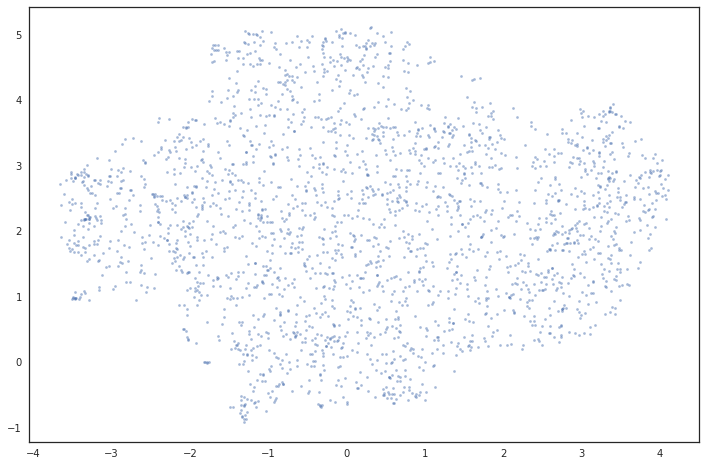

In [79]:
plot_scatter(mean_u)

### TensorBoard Embedding Projectorへ

In [80]:
import pandas as pd
limit = 5000
df = pd.DataFrame(ptbs.src.data).T
test_label_list = [ids2text(target, vocab.src.i2w) for target in df.target.tolist()]
from torch.utils.tensorboard import SummaryWriter
save_dir = f'{runs_dir}/{model_name}/vae_eccos_v2_embeddings'
print(save_dir)
writer = SummaryWriter(save_dir)
writer.add_embedding(torch.FloatTensor(encoded_mean_arr[:limit]), metadata=test_label_list[:limit])

/root/user/work/src/Sentence-VAE/runs/vae_eccos_v2_TS=2020-01-05-181436_BS=32_LR=0.001_EB=300_GRU_HS=256_L=1_BI=0_LS=16_WD=0_ANN=LOGISTIC_K=0.0025_X0=2500/vae_eccos_v2_embeddings
